# Quantization of Signals

*This jupyter notebook is part of a [collection of notebooks](../index.ipynb) on various topics of Digital Signal Processing. Please direct questions and suggestions to [Sascha.Spors@uni-rostock.de](mailto:Sascha.Spors@uni-rostock.de).*

## Spectral Shaping of the Quantization Noise

The quantized signal $x_Q[k]$ can be expressed by the continuous amplitude signal $x[k]$ and the quantization error $e[k]$ as

\begin{equation}
x_Q[k] = \mathcal{Q} \{ x[k] \} = x[k] + e[k]
\end{equation}

According to the [introduced model](linear_uniform_quantization_error.ipynb#Model-for-the-Quantization-Error), the quantization noise can be modeled as uniformly distributed white noise. Hence, the noise is distributed over the entire frequency range. The basic concept of [noise shaping](https://en.wikipedia.org/wiki/Noise_shaping) is a feedback of the quantization error to the input of the quantizer. This way the spectral characteristics of the quantization noise can be modified, i.e. spectrally shaped. Introducing a generic filter $h[k]$ into the feedback loop yields the following structure

![Feedback structure for noise shaping](noise_shaping.png)

The quantized signal can be deduced from the block diagram above as

\begin{equation}
x_Q[k] = \mathcal{Q} \{ x[k] - e[k] * h[k] \} = x[k] + e[k] - e[k] * h[k]
\end{equation}

where the additive noise model from above has been introduced and it has been assumed that the impulse response $h[k]$ is normalized such that the magnitude of $e[k] * h[k]$ is below the quantization step $Q$. The overall quantization error is then

\begin{equation}
e_H[k] = x_Q[k] - x[k] = e[k] * (\delta[k] - h[k])
\end{equation}

The power spectral density (PSD) of the quantization error with noise shaping is calculated to

\begin{equation}
\Phi_{e_H e_H}(\mathrm{e}^{\,\mathrm{j}\,\Omega}) = \Phi_{ee}(\mathrm{e}^{\,\mathrm{j}\,\Omega}) \cdot \left| 1 - H(\mathrm{e}^{\,\mathrm{j}\,\Omega}) \right|^2
\end{equation}

Hence the PSD $\Phi_{ee}(\mathrm{e}^{\,\mathrm{j}\,\Omega})$ of the quantizer without noise shaping is weighted by $| 1 - H(\mathrm{e}^{\,\mathrm{j}\,\Omega}) |^2$. Noise shaping allows a spectral modification of the quantization error. The desired shaping depends on the application scenario. For some applications, high-frequency noise is less disturbing as low-frequency noise.

### Example - First-Order Noise Shaping

If the feedback of the error signal is delayed by one sample we get with $h[k] = \delta[k-1]$

\begin{equation}
\Phi_{e_H e_H}(\mathrm{e}^{\,\mathrm{j}\,\Omega}) = \Phi_{ee}(\mathrm{e}^{\,\mathrm{j}\,\Omega}) \cdot \left| 1 - \mathrm{e}^{\,-\mathrm{j}\,\Omega} \right|^2
\end{equation}

For linear uniform quantization $\Phi_{ee}(\mathrm{e}^{\,\mathrm{j}\,\Omega}) = \sigma_e^2$ is constant. Hence, the spectral shaping constitutes a high-pass characteristic of first order. The following simulation evaluates the noise shaping quantizer of first order.

SNR = 45.2 dB


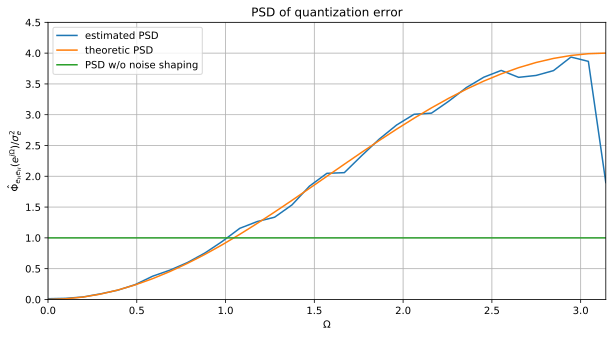

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.signal as sig
%matplotlib inline

w = 8  # wordlength of the quantized signal
xmin = -1  # minimum of input signal
N = 32768  # number of samples


def uniform_midtread_quantizer_w_ns(x, Q):
    # limiter
    x = np.copy(x)
    idx = np.where(x <= -1)
    x[idx] = -1
    idx = np.where(x > 1 - Q)
    x[idx] = 1 - Q
    # linear uniform quantization with noise shaping
    xQ = Q * np.floor(x/Q + 1/2)
    e = xQ - x
    xQ = xQ - np.concatenate(([0], e[0:-1]))

    return xQ[1:]


# quantization step
Q = 1/(2**(w-1))
# compute input signal
np.random.seed(5)
x = np.random.uniform(size=N, low=xmin, high=(-xmin-Q))
# quantize signal
xQ = uniform_midtread_quantizer_w_ns(x, Q)
e = xQ - x[1:]
# estimate PSD of error signal
nf, Pee = sig.welch(e, nperseg=64)
# estimate SNR
SNR = 10*np.log10((np.var(x)/np.var(e)))
print('SNR = {:2.1f} dB'.format(SNR))


plt.figure(figsize=(10, 5))
Om = nf*2*np.pi
plt.plot(Om, Pee*6/Q**2, label='estimated PSD')
plt.plot(Om, np.abs(1 - np.exp(-1j*Om))**2, label='theoretic PSD')
plt.plot(Om, np.ones(Om.shape), label='PSD w/o noise shaping')
plt.title('PSD of quantization error')
plt.xlabel(r'$\Omega$')
plt.ylabel(r'$\hat{\Phi}_{e_H e_H}(e^{j \Omega}) / \sigma_e^2$')
plt.axis([0, np.pi, 0, 4.5])
plt.legend(loc='upper left')
plt.grid()

**Exercise**

* The overall average SNR is lower than for the quantizer without noise shaping. Why?

Solution: The average power per frequency is lower that without noise shaping for frequencies below $\Omega \approx \pi$. However, this comes at the cost of a larger average power per frequency for frequencies above $\Omega \approx \pi$. The average power of the quantization noise is given as the integral over the PSD of the quantization noise. It is larger for noise shaping and the resulting SNR is consequently lower. Noise shaping is nevertheless beneficial in applications where a lower quantization error in a limited frequency region is desired.

**Copyright**

This notebook is provided as [Open Educational Resource](https://en.wikipedia.org/wiki/Open_educational_resources). Feel free to use the notebook for your own purposes. The text is licensed under [Creative Commons Attribution 4.0](https://creativecommons.org/licenses/by/4.0/), the code of the IPython examples under the [MIT license](https://opensource.org/licenses/MIT). Please attribute the work as follows: *Sascha Spors, Digital Signal Processing - Lecture notes featuring computational examples*.